https://medium.com/machine-learning-world/tutorial-making-road-traffic-counting-app-based-on-computer-vision-and-opencv-166937911660

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
from tqdm import tqdm_notebook as tqdm
import time

%matplotlib inline

In [12]:
# Parameters
input_video_path = './examples/AB17-0830H.avi'
target_frame = 10 

video = cv.VideoCapture(input_video_path)
count = 0

while count < target_frame:
    ret, sample_frame = video.read()
    if ret: 
        count += 1
    else:
        break

video.release()

img_height = sample_frame.shape[0]
img_width = sample_frame.shape[1]

In [30]:
# creting MOG bg subtractor with 500 frames in cache
# and shadow detction
num = 500

cap = []
video = cv.VideoCapture(input_video_path)
i = 0
while i < num:
    ret, frame = video.read()
    cap.append(frame)
    i += 1
    if ret == False:
        break
    
video.release()
cap = np.array(cap)

In [32]:
bg_subtractor = cv.createBackgroundSubtractorMOG2(history=num, detectShadows=True)
for frame in cap:
    fgmask = bg_subtractor.apply(frame, None, 0.001)
test = bg_subtractor.getBackgroundImage(cap)

In [56]:
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (2, 2))

# Fill any small holes
closing = cv.morphologyEx(fgmask, cv.MORPH_CLOSE, kernel)

# Remove noise
opening = cv.morphologyEx(closing, cv.MORPH_OPEN, kernel)

# Dilate to merge adjacent blobs
dilation = cv.dilate(opening, kernel, iterations=2)

# threshold
th = dilation[dilation < 240] = 0

fg_mask = dilation

In [47]:
def get_centroid(x, y, w, h):
    x1 = int(w / 2)
    y1 = int(h / 2)

    cx = x + x1
    cy = y + y1

    return (cx, cy)

In [59]:
min_contour_width = 30
min_contour_height = 30

matches = []

# finding external contours
im, contours, hierarchy = cv.findContours(
    fg_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_TC89_L1)

# filtering by with, height
for (i, contour) in enumerate(contours):
    (x, y, w, h) = cv.boundingRect(contour)
    contour_valid = (w >= min_contour_width) and (
        h >= min_contour_height)

    if not contour_valid:
        continue

    # getting center of the bounding box
    centroid = get_centroid(x, y, w, h)

    matches.append(((x, y, w, h), centroid))

In [113]:
def contour_to_pts(contour):
    (x, y, w, h), _ = contour
    pt1 = [x, y]
    pt2 = [x + w, y]
    pt3 = [x + w, y + h]
    pt4 = [x, y + h]
    return np.array([pt1, pt2, pt3, pt4])

In [132]:
img = frame.copy()

for match in matches:
    pts = contour_to_pts(match)
    #pts = pts.reshape((-1,1,2))
    cv.polylines(img, [pts], True, (0,255,0), thickness = 3)

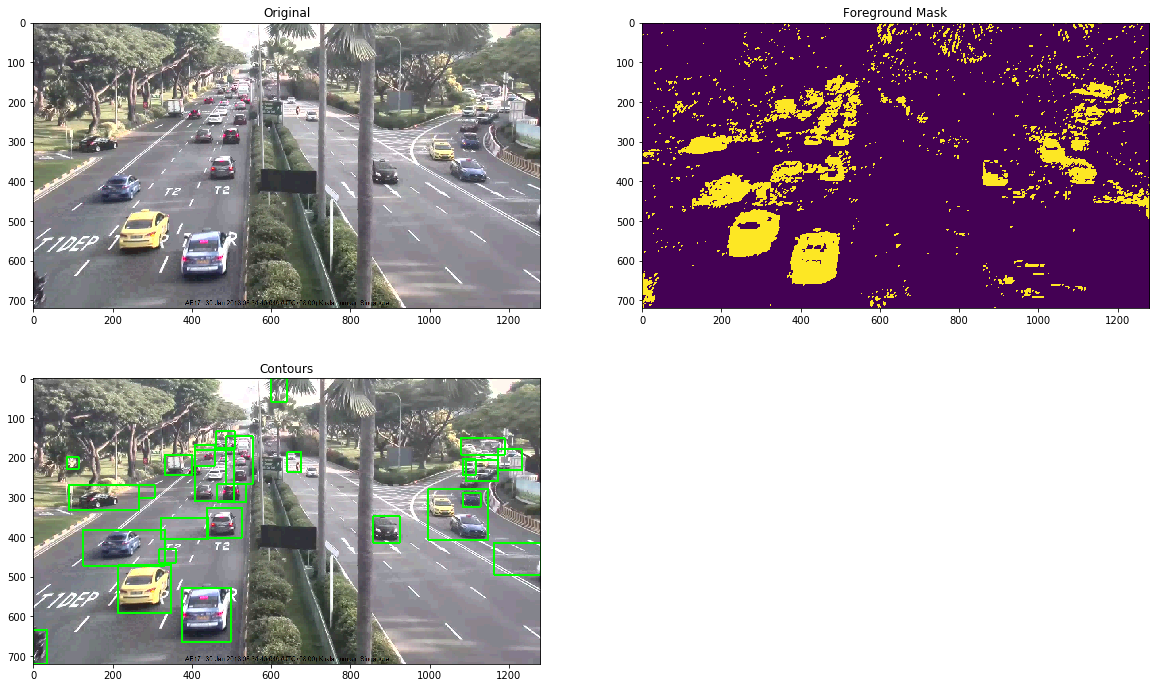

In [133]:
fig = plt.figure(figsize=(20,12))
plt.subplot(221),plt.imshow(cv.cvtColor(frame, cv.COLOR_BGR2RGB)),plt.title('Original')
plt.subplot(222),plt.imshow(dilation),plt.title('Foreground Mask')
plt.subplot(223),plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB)),plt.title('Contours')
plt.show()